# Средняя зарплата

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [118]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


C:\javasdk\anakonda\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


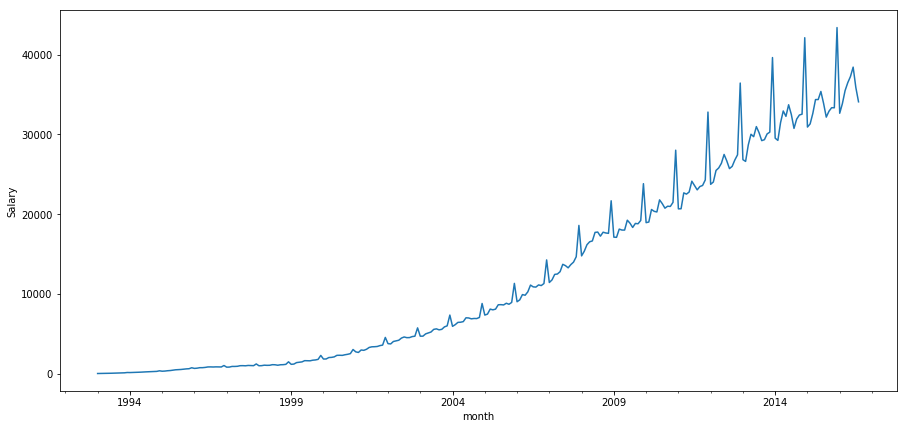

In [119]:
s = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'], 
                parse_dates=['month'], dayfirst=True).rename(index=str, columns={"WAG_C_M":"salary"})
s = s.set_index(pd.to_datetime(s.index))
plt.figure(figsize(15,7))
s.salary.plot()
plt.ylabel('Salary')
pylab.show()

Видим якро выраженный тренд, сезонность и различие дисперсий.

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

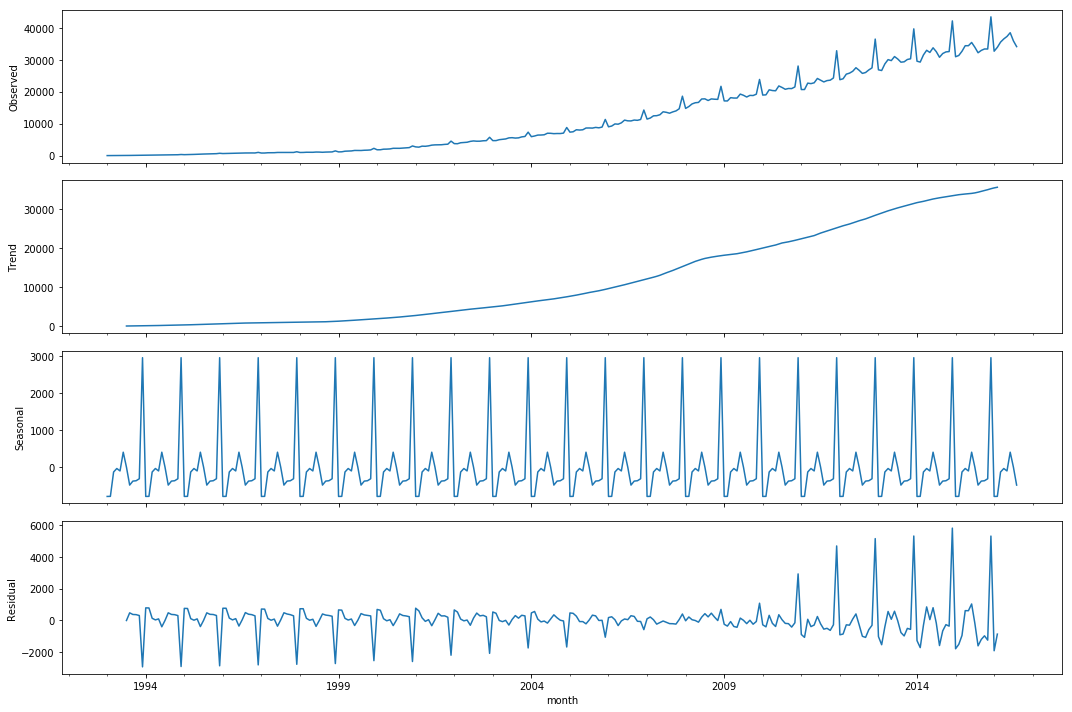

In [120]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(s.salary).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(s.salary)[1])

Сам внешний вид ряда (тренд+сезонность) + pvalue теста говорит о том, что ряд оень вероятно нестационарен.

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


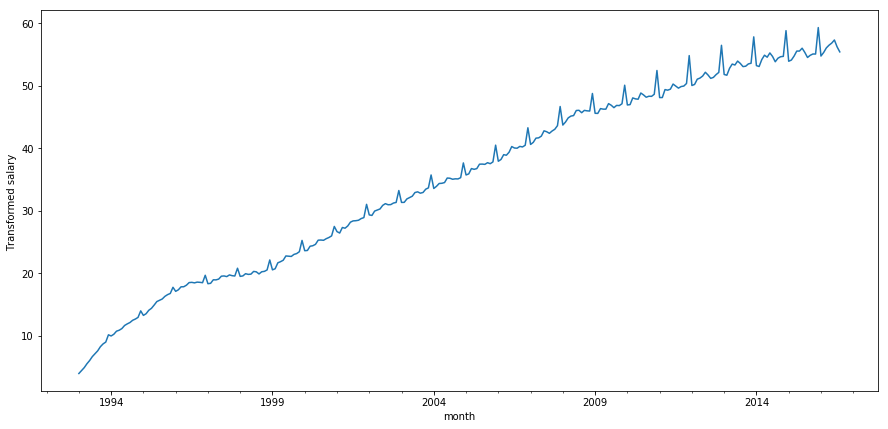

In [121]:
s['salary_box'], lmbda = stats.boxcox(s.salary)
plt.figure(figsize(15,7))
s.salary_box.plot()
plt.ylabel(u'Transformed salary ')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(s.salary_box)[1])

После преобразования все равно дисперсия не стабилизировалась + критерий не позволяет принять гипотезу о стационарности ряда с хорошим уровнем значимости.

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

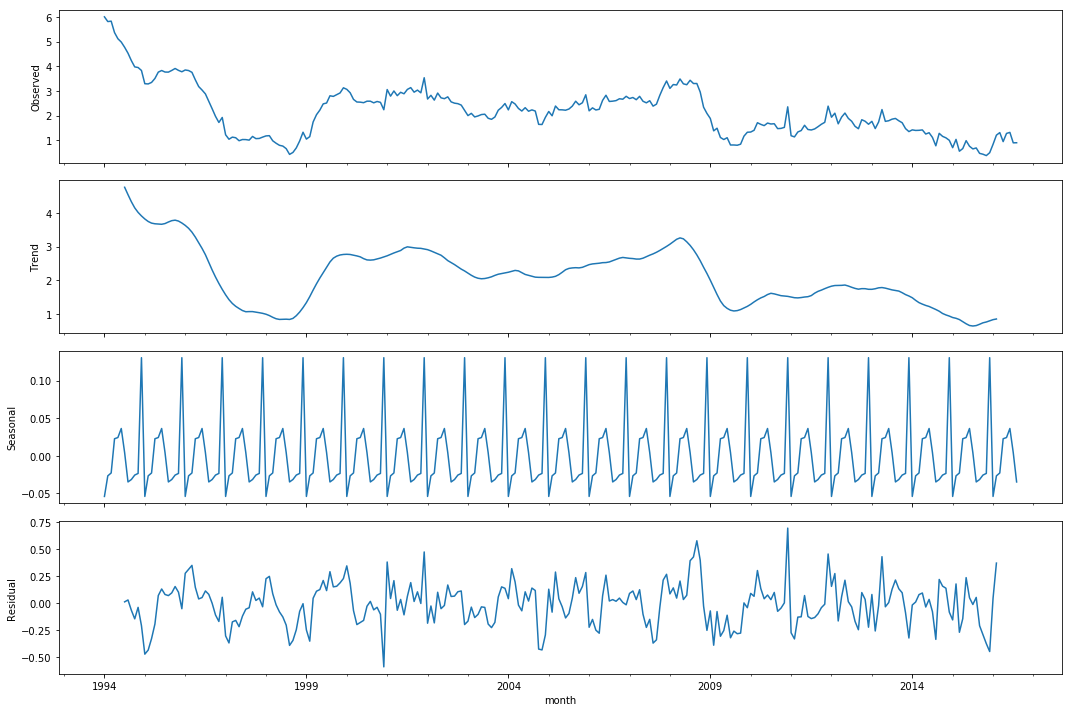

In [122]:
s['salary_box_diff'] = s.salary_box - s.salary_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(s.salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(s.salary_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

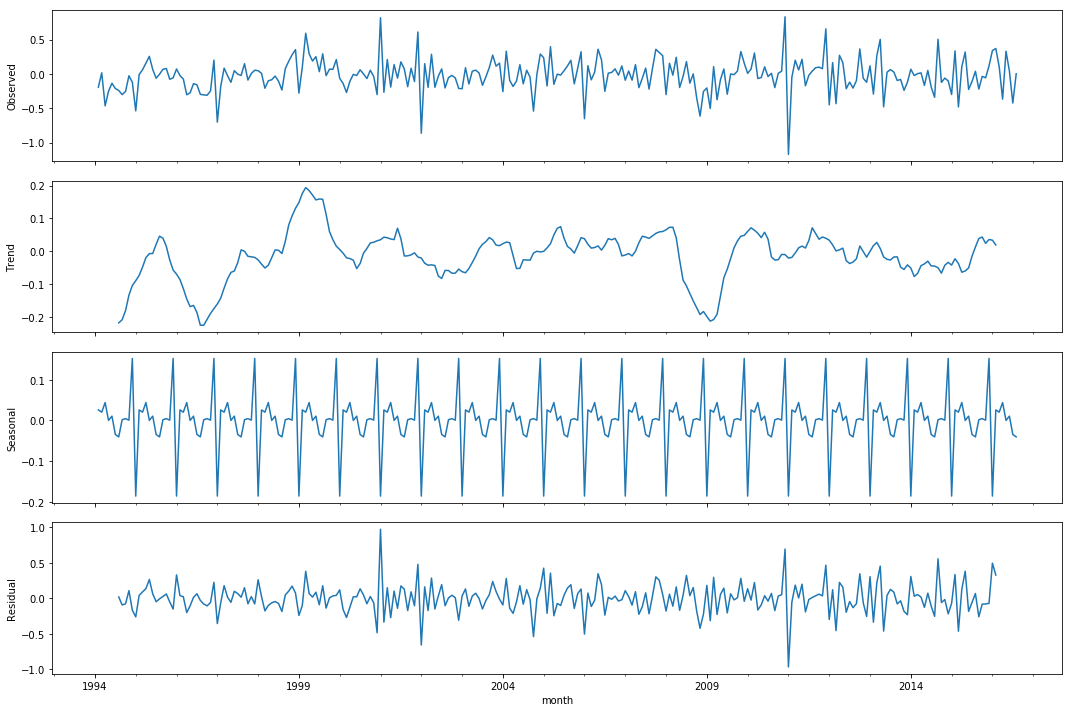

In [123]:
s['salary_box_diff2'] = s.salary_box_diff - s.salary_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(s.salary_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(s.salary_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

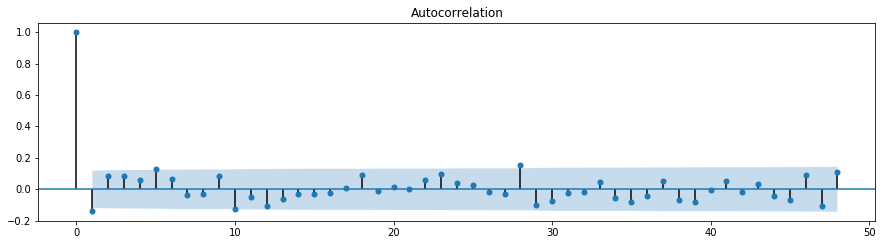

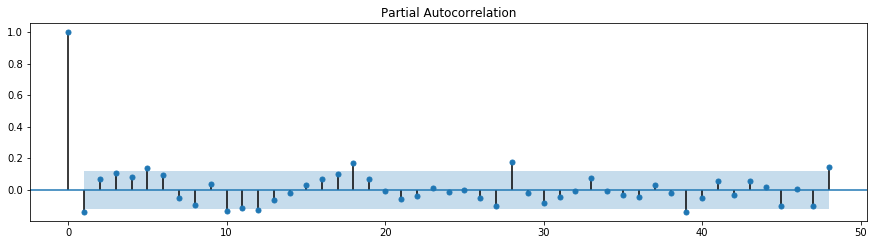

In [124]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(s.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(s.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Выбираем начальные приближения


По коррелограмме автокорреляций: 

Максимальный сезонный значимый лаг = 0 = 0*12 ; 0 = Q

Максимальный несезонный значимый лаг, меньший сезона (12) = 5 ; 5 = q


По коррелограмме частичных автокорреляций: 

Максимальный сезонный значимый лаг = 48 =  4*12 ; 4 = P

Максимальный несезонный значимый лаг, меньший сезона (12) = 10; 10 = p

Начальные приближения: Q=0, q=6, P=4, p=10

In [125]:
ps = range(0, 11)
d=1
qs = range(0, 6)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

In [126]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

330

In [ ]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(s.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head(144))

Лучшая модель:

In [ ]:
print(best_model.summary())

Её остатки:

In [ ]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

In [ ]:
s['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
s.salary.plot()
s.model[13:].plot(color='r')
plt.ylabel('Salary')
pylab.show()

Вроде хорошо:)

### Прогноз

In [ ]:
s2 = s[['salary']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= s2.columns)
s2 = pd.concat([s2, future])
s2['forecast'] = invboxcox(best_model.predict(start=284, end=308), lmbda)

plt.figure(figsize(15,7))
s2.salary.plot()
s2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()

Прогноз учел характер временного ряда, кажется вполне адекватным

### Прогноз обычными средствами ML

Прогноз выполнится  с помощью регрессии, при это учтем окно около 5 значений назад

In [ ]:
s_ml = s.copy()

In [ ]:
s_ml.reset_index(inplace=True)

In [ ]:
for i in range(1, 11):
    s_ml['next' + str(i)] = s_ml['salary'].shift(-i)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
regr = RandomForestRegressor()

In [ ]:
s_fit = s_ml.iloc[:-11, :]

In [ ]:
regr.fit(s_fit[['salary', 'next1', 'next2', 'next3', 'next4', 'next5', 'next6', 'next7', 'next8', 'next9']], s_fit['next10'])

In [ ]:
list_value = s['salary'].tolist()

In [ ]:
for i in range(1, 20):
    n = regr.predict(np.array(list_value[-11: -1]).reshape([1,10]))
    list_value.append(n)

In [ ]:
plt.plot(list_value)

Явно не хватает окна и не хватает данных, чем больше окно, тем больше поймаем только тренд